In [1]:
import os, sys
os.chdir("..")
sys.path.append(".")  
os.getcwd()

'/Users/sbhandari/Documents/GitHub/epsilon-transformers'

In [ ]:
from epsilon_transformers.persistence import LocalPersister, S3Persister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.training.configs.training_configs import TrainConfig
from pathlib import Path
persister = LocalPersister(collection_location=Path("models/mess3"))


/opt/anaconda3/envs/epstrans311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/anaconda3/envs/epstrans311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because a

In [11]:
import numpy as np

In [3]:
import os
print("Current working directory:", os.getcwd())
print("Contents:", os.listdir())

from pathlib import Path
print("Resolved path:", Path("models/mess3").resolve())

Current working directory: /Users/sbhandari/Documents/GitHub/epsilon-transformers
Contents: ['.DS_Store', 'epsilon_transformers', 'experiments', 'pyproject.toml', 'epsilon_transformers.egg-info', 'tests', 'models', 'README.md', '.gitignore', 'examples', 'scripts', '.git']
Resolved path: /Users/sbhandari/Documents/GitHub/epsilon-transformers/models/mess3


In [4]:
model = RawModelConfig(
        d_vocab=3,
        d_model=64,
        n_ctx=10,
        d_head=8,
        n_head=1,
        d_mlp=256,
        n_layers=4,
    ).to_hooked_transformer(seed=1337, device='cpu')

persister.load_model(model,'640000.pt')

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

In [5]:
from epsilon_transformers.process.processes import Mess3
process = Mess3(x=0.15,a=0.6)

In [6]:
process.transition_matrix

array([[[0.42, 0.03, 0.03],
        [0.09, 0.14, 0.03],
        [0.09, 0.03, 0.14]],

       [[0.14, 0.09, 0.03],
        [0.03, 0.42, 0.03],
        [0.03, 0.09, 0.14]],

       [[0.14, 0.03, 0.09],
        [0.03, 0.14, 0.09],
        [0.03, 0.03, 0.42]]])

In [7]:
process.state_names_dict

{'A': 0, 'B': 1, 'C': 2}

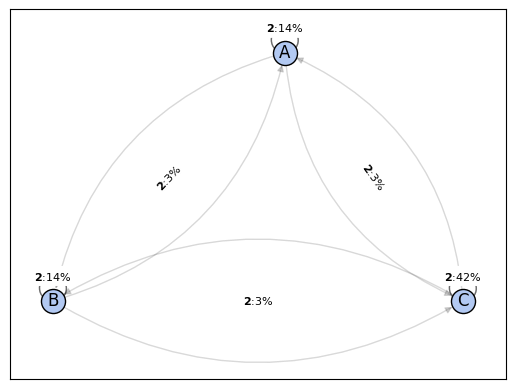

In [8]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph

graph = transition_matrix_to_graph(transition_matrix=process.transition_matrix,state_names=process.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout='spectral')

In [9]:
mixed_state_tree = process.derive_mixed_state_presentation(depth=11)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

In [10]:
# make a process out of the transition matrix
from epsilon_transformers.process.processes import TransitionMatrixProcess
process = TransitionMatrixProcess(transition_matrix=MSP_transition_matrix)
graph = transition_matrix_to_graph(transition_matrix=MSP_transition_matrix)
visualize_graph(graph, draw_mixed_state=True, layout='spectral', draw_edge_labels=False, draw_color=False)


: 

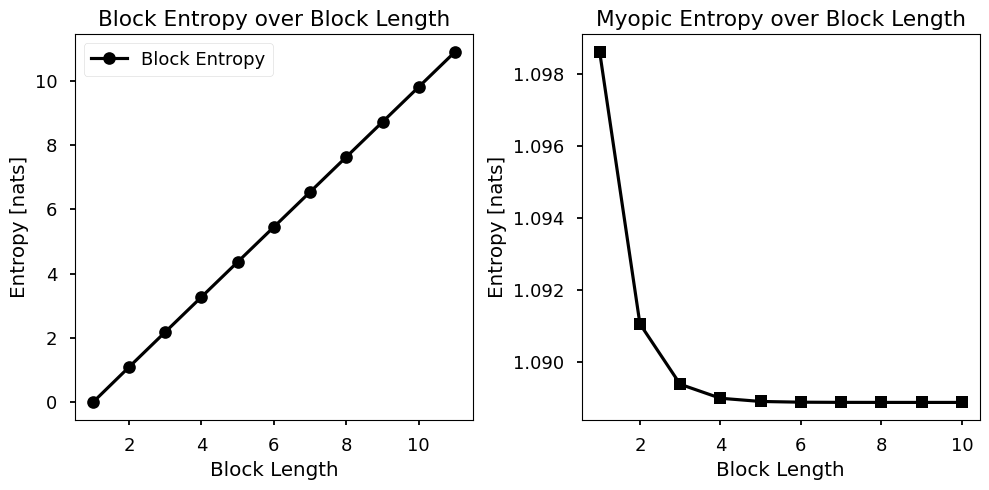

In [12]:
# compute the myopic entropy rate from the msp
block_entropy = mixed_state_tree.block_entropy
myopic_entropy = mixed_state_tree.myopic_entropy

# use seaborn to plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-talk')
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plotting Block Entropy
axs[0].plot(np.arange(1, len(block_entropy) + 1), block_entropy, label='Block Entropy', color='black', marker='o', linestyle='-')
axs[0].set_title('Block Entropy over Block Length')
axs[0].set_xlabel('Block Length')
axs[0].set_ylabel('Entropy [nats]')
axs[0].legend()

# Plotting Myopic Entropy
axs[1].plot(np.arange(1, len(myopic_entropy) + 1), myopic_entropy, label='Myopic Entropy', color='black', marker='s', linestyle='-')
axs[1].set_title('Myopic Entropy over Block Length')
axs[1].set_xlabel('Block Length')
axs[1].set_ylabel('Entropy [nats]')
plt.tight_layout()
plt.show()


In [13]:
import torch
import numpy as np
from typing import Tuple, Dict, List, Optional
import matplotlib.pyplot as plt


In [ ]:
def compute_mixed_states_from_sequence(
    process,
    sequence: np.ndarray,
    initial_state_dist: Optional[np.ndarray] = None
) -> List[np.ndarray]:
    n_states = process.num_states
    T = process.transition_matrix
    
    if initial_state_dist is None:
        eta = np.ones(n_states) / n_states
    else:
        eta = initial_state_dist.copy()
        eta = eta / eta.sum()
    
    mixed_states = [eta.copy()]
    
    for token in sequence:
        eta_next_unnorm = eta @ T[token]
        total = eta_next_unnorm.sum()
        if total > 1e-10:
            eta_next = eta_next_unnorm / total
        else:
            eta_next = np.ones(n_states) / n_states
        
        mixed_states.append(eta_next.copy())
        eta = eta_next
    
    return mixed_states


def token_probabilities_from_mixed_state(
    process,
    eta: np.ndarray
) -> np.ndarray:
    T = process.transition_matrix
    vocab_len = process.vocab_len
    
    token_probs = np.zeros(vocab_len)
    ones = np.ones(process.num_states)
    
    for token_idx in range(vocab_len):
        prob = eta @ T[token_idx] @ ones
        token_probs[token_idx] = prob
    
    total = token_probs.sum()
    if total > 1e-10:
        token_probs = token_probs / total
    else:
        token_probs = np.ones(vocab_len) / vocab_len
    
    return token_probs


def generate_sequences(
    process, 
    n_gen: int, 
    gen_len: int,
    initial_state_idx: Optional[int] = None
) -> np.ndarray:
    sequences = []
    
    for _ in range(n_gen):
        history = process.generate_process_history(
            total_length=gen_len,
            current_state_idx=initial_state_idx
        )
        sequences.append(history.symbols)
    
    return np.array(sequences)


In [50]:
def compute_myopic_rates(
    model,
    process,
    n_samples: int = 1000,
    seq_len: int = 10,
    device: str = 'cpu'
) -> Dict[str, np.ndarray]:
    """
    Compute myopic entropy rate and myopic cross-entropy rate at each position.
    
    Based on the paper formulation:
    - Myopic cross-entropy rate: c_ℓ^(Pr_θ, Q) = -⟨log Pr_θ(X_ℓ | X_{1:ℓ-1})⟩_{Q(X_{1:ℓ})}
    - Myopic entropy rate: h_ℓ^Q = -⟨log Q(X_ℓ | X_{1:ℓ-1})⟩_{Q(X_{1:ℓ})}
    
    The inequality: c_ℓ^(Pr_θ, Q) ≥ h_ℓ^Q holds at each position ℓ
    
    Args:
        model: Trained transformer model (HookedTransformer)
        process: Markov process (e.g., Mess3)
        n_samples: Number of sequences to generate
        seq_len: Length of sequences (should match model.cfg.n_ctx)
        device: Device for computation
    
    Returns:
        Dictionary containing:
        - 'myopic_cross_entropy': Array of shape (seq_len,) with c_ℓ at each position
        - 'myopic_entropy': Array of shape (seq_len,) with h_ℓ at each position
        - 'per_sequence_cross_entropy': Array of shape (n_samples, seq_len)
        - 'per_sequence_entropy': Array of shape (n_samples, seq_len)
        - 'sequences': The generated sequences
    """
    sequences = generate_sequences(process, n_gen=n_samples, gen_len=seq_len)

    x = torch.tensor(sequences, dtype=torch.long, device=device)
    per_seq_cross_entropy = np.zeros((n_samples, seq_len))
    per_seq_entropy = np.zeros((n_samples, seq_len))

    model.eval()
    with torch.no_grad():
        logits = model(x)  # Shape: (n_samples, seq_len, vocab_size)
        log_probs = torch.log_softmax(logits, dim=-1)
        for ell in range(seq_len):
            actual_tokens = x[:, ell]

            if ell == 0:
                # For first position, model has no context (empty history)
                # Use prediction from position 0
                log_prob_at_ell = torch.stack([
                    log_probs[i, 0, actual_tokens[i]] for i in range(n_samples)
                ])
            else:
                # Model output at position ℓ-1 predicts position ℓ
                log_prob_at_ell = torch.stack([
                    log_probs[i, ell-1, actual_tokens[i]] for i in range(n_samples)
                ])
            
            # Cross-entropy at position ℓ: -log Pr_θ(X_ℓ | X_{1:ℓ-1})
            per_seq_cross_entropy[:, ell] = -log_prob_at_ell.cpu().numpy()
    
    # ========================================================================
    # Compute myopic entropy rate: h_ℓ^Q
    # This is: -⟨log Q(X_ℓ | X_{1:ℓ-1})⟩_{Q(X_{1:ℓ})}
    # ========================================================================
    
    for seq_idx, seq in enumerate(sequences):
        mixed_states = compute_mixed_states_from_sequence(process, seq)
        
        for ell in range(seq_len):
            eta = mixed_states[ell]
            token_probs = token_probabilities_from_mixed_state(process, eta)
            actual_token = seq[ell]
            
            # Entropy at position ℓ: -log Q(X_ℓ | X_{1:ℓ-1})
            prob_actual = token_probs[actual_token]
            per_seq_entropy[seq_idx, ell] = -np.log(prob_actual + 1e-10)
    
    eps = 1e-10
    per_seq_relative_entropy = per_seq_cross_entropy / (per_seq_entropy + eps)

    myopic_cross_entropy = per_seq_cross_entropy.mean(axis=0)
    myopic_entropy = per_seq_entropy.mean(axis=0)
    relative_entropy_rate = per_seq_relative_entropy.mean(axis=0)
    
    return {
        'myopic_cross_entropy': myopic_cross_entropy,
        'myopic_entropy': myopic_entropy,
        'per_sequence_cross_entropy': per_seq_cross_entropy,
        'per_sequence_entropy': per_seq_entropy,
        'relative_entropy_rate': relative_entropy_rate,
        'per_sequence_relative_entropy': per_seq_relative_entropy,
        'sequences': sequences
    }


In [55]:
results = compute_myopic_rates(
    model=model,
    process=process,
    n_samples=10000,
    seq_len=10,
    device='cpu'
)
myopic_ce = results['myopic_cross_entropy']
myopic_h = results['myopic_entropy']
relative_rate = results['relative_entropy_rate']

seq_len = len(myopic_ce)
print(f"{'Position':<10} {'Cross-Entropy':<20} {'Entropy':<20} {'Gap':<15} {'Relative':<15}")
print("-"*95)
for pos in range(seq_len):
    ce = myopic_ce[pos]
    h = myopic_h[pos]
    gap = ce - h
    rel = relative_rate[pos]
    print(f"{pos+1:<10} {ce:<20.6f} {h:<20.6f} {gap:<15.6f} {rel:<15.6f}")
pos=9
for i in range(9):
    seq = results['sequences'][i]
    ce_seq = results['per_sequence_cross_entropy'][i][pos]
    h_seq = results['per_sequence_entropy'][i][pos]
    rel_seq = results['per_sequence_relative_entropy'][i][pos]
    print(f"Sequence {i+1}: {' '.join(map(str, seq))}")
    print(f"  Cross-Entropy: {ce_seq}")
    print(f"  Entropy:       {h_seq}")
    print(f"  Relative:      {rel_seq}")
   

Position   Cross-Entropy        Entropy              Gap             Relative       
-----------------------------------------------------------------------------------------------
1          0.399968             1.098612             -0.698644       0.364067       
2          1.252731             1.090915             0.161815        1.087871       
3          1.231475             1.089936             0.141539        1.067864       
4          1.237520             1.090807             0.146713        1.072442       
5          1.225884             1.087673             0.138211        1.064687       
6          1.218901             1.086340             0.132560        1.058626       
7          1.237302             1.087849             0.149454        1.073866       
8          1.233773             1.088155             0.145617        1.071793       
9          1.230823             1.086859             0.143965        1.071261       
10         1.227998             1.087275             0